In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
file_path = "filtered_data_kalman.xlsx"
df = pd.read_excel(file_path)

In [4]:
df.head()

,Entry,R,G,B,L,a,b,H,S,V,pH
0,1,132.421900,138.229800,53.935900,54.928100,-13.554800,41.861400,76.294800,65.869500,54.324000,6.0
1,2,138.637048,143.986971,59.568733,57.070434,-13.376742,41.729290,77.730742,64.337488,56.584362,6.0
2,3,140.270149,146.899660,70.360437,58.191672,-13.138922,37.839298,80.374934,58.423249,57.758332,6.0
3,4,138.995971,147.176499,73.962323,58.223417,-13.442850,36.100567,81.705812,56.246422,57.853953,6.0
4,5,142.074601,149.007879,71.115780,58.929880,-13.389615,38.329525,79.346646,58.159746,58.562525,6.0


In [5]:
features = ['R', 'G', 'B', 'L', 'a', 'b', 'H', 'S', 'V']
X = df[features].values
Y = df['pH']

In [6]:
print(X[:5])
print(Y[:5])

[[132.4219     138.2298      53.9359      54.9281     -13.5548
   41.8614      76.2948      65.8695      54.324     ]
 [138.63704761 143.98697125  59.56873283  57.07043425 -13.37674154
   41.72929043  77.73074183  64.33748797  56.58436187]
 [140.27014941 146.89965951  70.36043706  58.1916723  -13.13892163
   37.83929765  80.37493445  58.42324907  57.75833245]
 [138.99597131 147.1764987   73.96232342  58.22341726 -13.44284971
   36.10056662  81.7058124   56.24642155  57.85395327]
 [142.07460103 149.00787892  71.11577976  58.92987955 -13.38961461
   38.32952542  79.34664646  58.15974577  58.56252525]]
0    6.0
1    6.0
2    6.0
3    6.0
4    6.0
Name: pH, dtype: float64


In [7]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [8]:
epsilon = 1.0          
path_length = 1.0      
physics_weight = 0.01   

In [9]:
def build_pinn(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(256, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

In [10]:
def physics_informed_loss(y_true, y_pred, inputs):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # --- Beer-Lambert Component ---
    c_H_pred = tf.pow(10.0, -y_pred)

    R = inputs[:, 0] * 255.0
    G = inputs[:, 1] * 255.0
    B = inputs[:, 2] * 255.0

    A_R = -tf.math.log(R / 255.0 + 1e-8)
    A_G = -tf.math.log(G / 255.0 + 1e-8)
    A_B = -tf.math.log(B / 255.0 + 1e-8)

    L = inputs[:, 3] * 100.0
    a = inputs[:, 4]
    b = inputs[:, 5]
    A_L = -tf.math.log(L / 100.0 + 1e-8)
    A_ab = -tf.math.log((tf.abs(a) + tf.abs(b)) / 256.0 + 1e-8)
    A_LAB = (A_L + A_ab) / 2.0

    H = inputs[:, 6] * 360.0
    S = inputs[:, 7]
    V = inputs[:, 8]
    A_H = -tf.math.log((H / 360.0) + 1e-8)
    A_SV = -tf.math.log(S * V + 1e-8)
    A_HSV = (A_H + A_SV) / 2.0

    A_combined = (A_R + A_G + A_B + A_LAB + A_HSV) / 5.0
    A_pred = c_H_pred * epsilon * path_length

    beer_lambert_loss = tf.reduce_mean(tf.square(A_combined - A_pred))

    # --- Henderson-Hasselbalch Component ---
    pKa = 7.0  # Adjust based on dye
    ratio_proxy = R / (B + 1e-8)  # Proxy for [Base]/[Acid]
    pH_eq = pKa + tf.math.log(ratio_proxy + 1e-8) / tf.math.log(10.0)
    equilibrium_loss = tf.reduce_mean(tf.square(y_pred - pH_eq))

    # Total physics loss
    total_physics_loss = (
        physics_weight * beer_lambert_loss +
        0.01 * equilibrium_loss  
    )

    return mse_loss + total_physics_loss

In [11]:
class PINNLoss(tf.keras.losses.Loss):
    def __init__(self, inputs):
        super().__init__()
        self.inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)

    def call(self, y_true, y_pred):
        return physics_informed_loss(y_true, y_pred, self.inputs)

In [12]:
pinn_model = build_pinn(X_train.shape[1])
pinn_model.compile(optimizer='adam', loss=PINNLoss(X_train))

2025-05-28 19:05:36.354736: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-28 19:05:36.354806: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-28 19:05:36.354814: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1748430336.355266  282146 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748430336.355680  282146 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
history = pinn_model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/500


2025-05-28 19:05:39.044047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 24.1024 - val_loss: 1.5865
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2200 - val_loss: 0.2921
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3254 - val_loss: 0.2210
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2390 - val_loss: 0.2150
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2511 - val_loss: 0.2098
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2569 - val_loss: 0.2086
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2203 - val_loss: 0.2097
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1967 - val_loss: 0.2034
Epoch 9/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2322 - val_loss: 0.1981
Epoch 10/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2264 - val_loss: 0.2343
Epoch 11/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2495 - val_loss: 0.1930
Epoch 12/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2255 - v

In [14]:
y_pred_train = pinn_model.predict(X_train)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print(f"R² Score: {r2_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R² Score: 0.9747
MSE: 0.0338
RMSE: 0.1840
MAE: 0.1215


In [15]:
y_pred = pinn_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [16]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R² Score: 0.9761
MSE: 0.0386
RMSE: 0.1966
MAE: 0.1279


/var/folders/91/fy46pnw16f325gv2clgyldjw0000gn/T/ipykernel_29045/3511689067.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_ticks = np.arange(np.floor(min(y_pred)), np.ceil(max(y_pred)) + 1, 1)


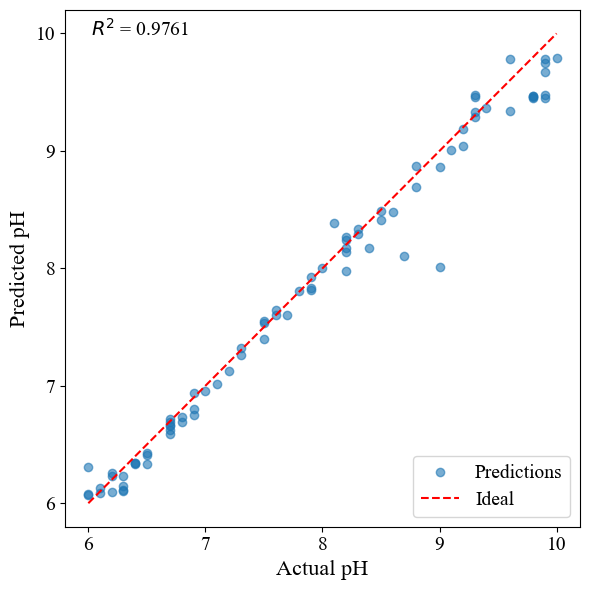

In [27]:
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal')
plt.xlabel("Actual pH", fontsize=16)
plt.ylabel("Predicted pH", fontsize=16)
plt.text(0.05, 0.985, f"$R^2$ = {r2:.4f}",
         transform=plt.gca().transAxes,
         fontsize=14,
         ha='left',
         va='top',
         color='black')
x_ticks = np.arange(np.floor(min(y_test)), np.ceil(max(y_test)) + 1, 1)
y_ticks = np.arange(np.floor(min(y_pred)), np.ceil(max(y_pred)) + 1, 1)
plt.xticks(x_ticks, fontsize=14)
plt.yticks(y_ticks, fontsize=14)
plt.grid(False)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("PINN.png", dpi=300, bbox_inches='tight')
plt.show()